In [1]:
#
# Author Stephan Janssen
#

# Clone GIT project
!git clone https://github.com/stephanj/basketballVideoAnalysis.git basketball

# Get inference graph weights 
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/frozen_inference_graph.pb

# import the necessary packages
import numpy as np
import argparse
import random
import time
import cv2
import os
from google.colab.patches import cv2_imshow

RED_COLOR = np.array([255, 0, 0]) 
BLACK_COLOR = np.array([255, 255, 255]) 

# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = "./frozen_inference_graph.pb"
configPath = "basketball/mask-rcnn/mask-rcnn-coco/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"

# load our Mask R-CNN trained on the COCO dataset (90 classes) from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

Cloning into 'basketball'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 189 (delta 16), reused 1 (delta 0), pack-reused 159
Receiving objects: 100% (189/189), 104.30 MiB | 29.17 MiB/s, done.
Resolving deltas: 100% (62/62), done.
--2019-12-19 16:36:12--  https://basketball-ml.s3-eu-west-1.amazonaws.com/frozen_inference_graph.pb
Resolving basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)... 52.218.100.88
Connecting to basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)|52.218.100.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67138064 (64M) [application/x-www-form-urlencoded]
Saving to: ‘frozen_inference_graph.pb’

frozen_inference_gr 100%[===================>]  64.03M  15.8MB/s    in 4.0s    

2019-12-19 16:36:17 (15.8 MB/s) - ‘frozen_inference_graph.pb’ saved [67138064/67138064]

[INFO] l

In [2]:

# load our input image and grab its spatial dimensions
image = cv2.imread("basketball/mask-rcnn/images/basketball.jpg", cv2.IMREAD_UNCHANGED)
(H, W) = image.shape[:2]
print("[INFO] image size: {}x{} pixels".format(W, H))


[INFO] image size: 2968x1314 pixels


In [3]:
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] boxes size: {}".format(boxes.size))
print("[INFO] masks shape: {}".format(masks.shape))


[INFO] Mask R-CNN took 17.627211 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] boxes size: 700
[INFO] masks shape: (100, 90, 15, 15)


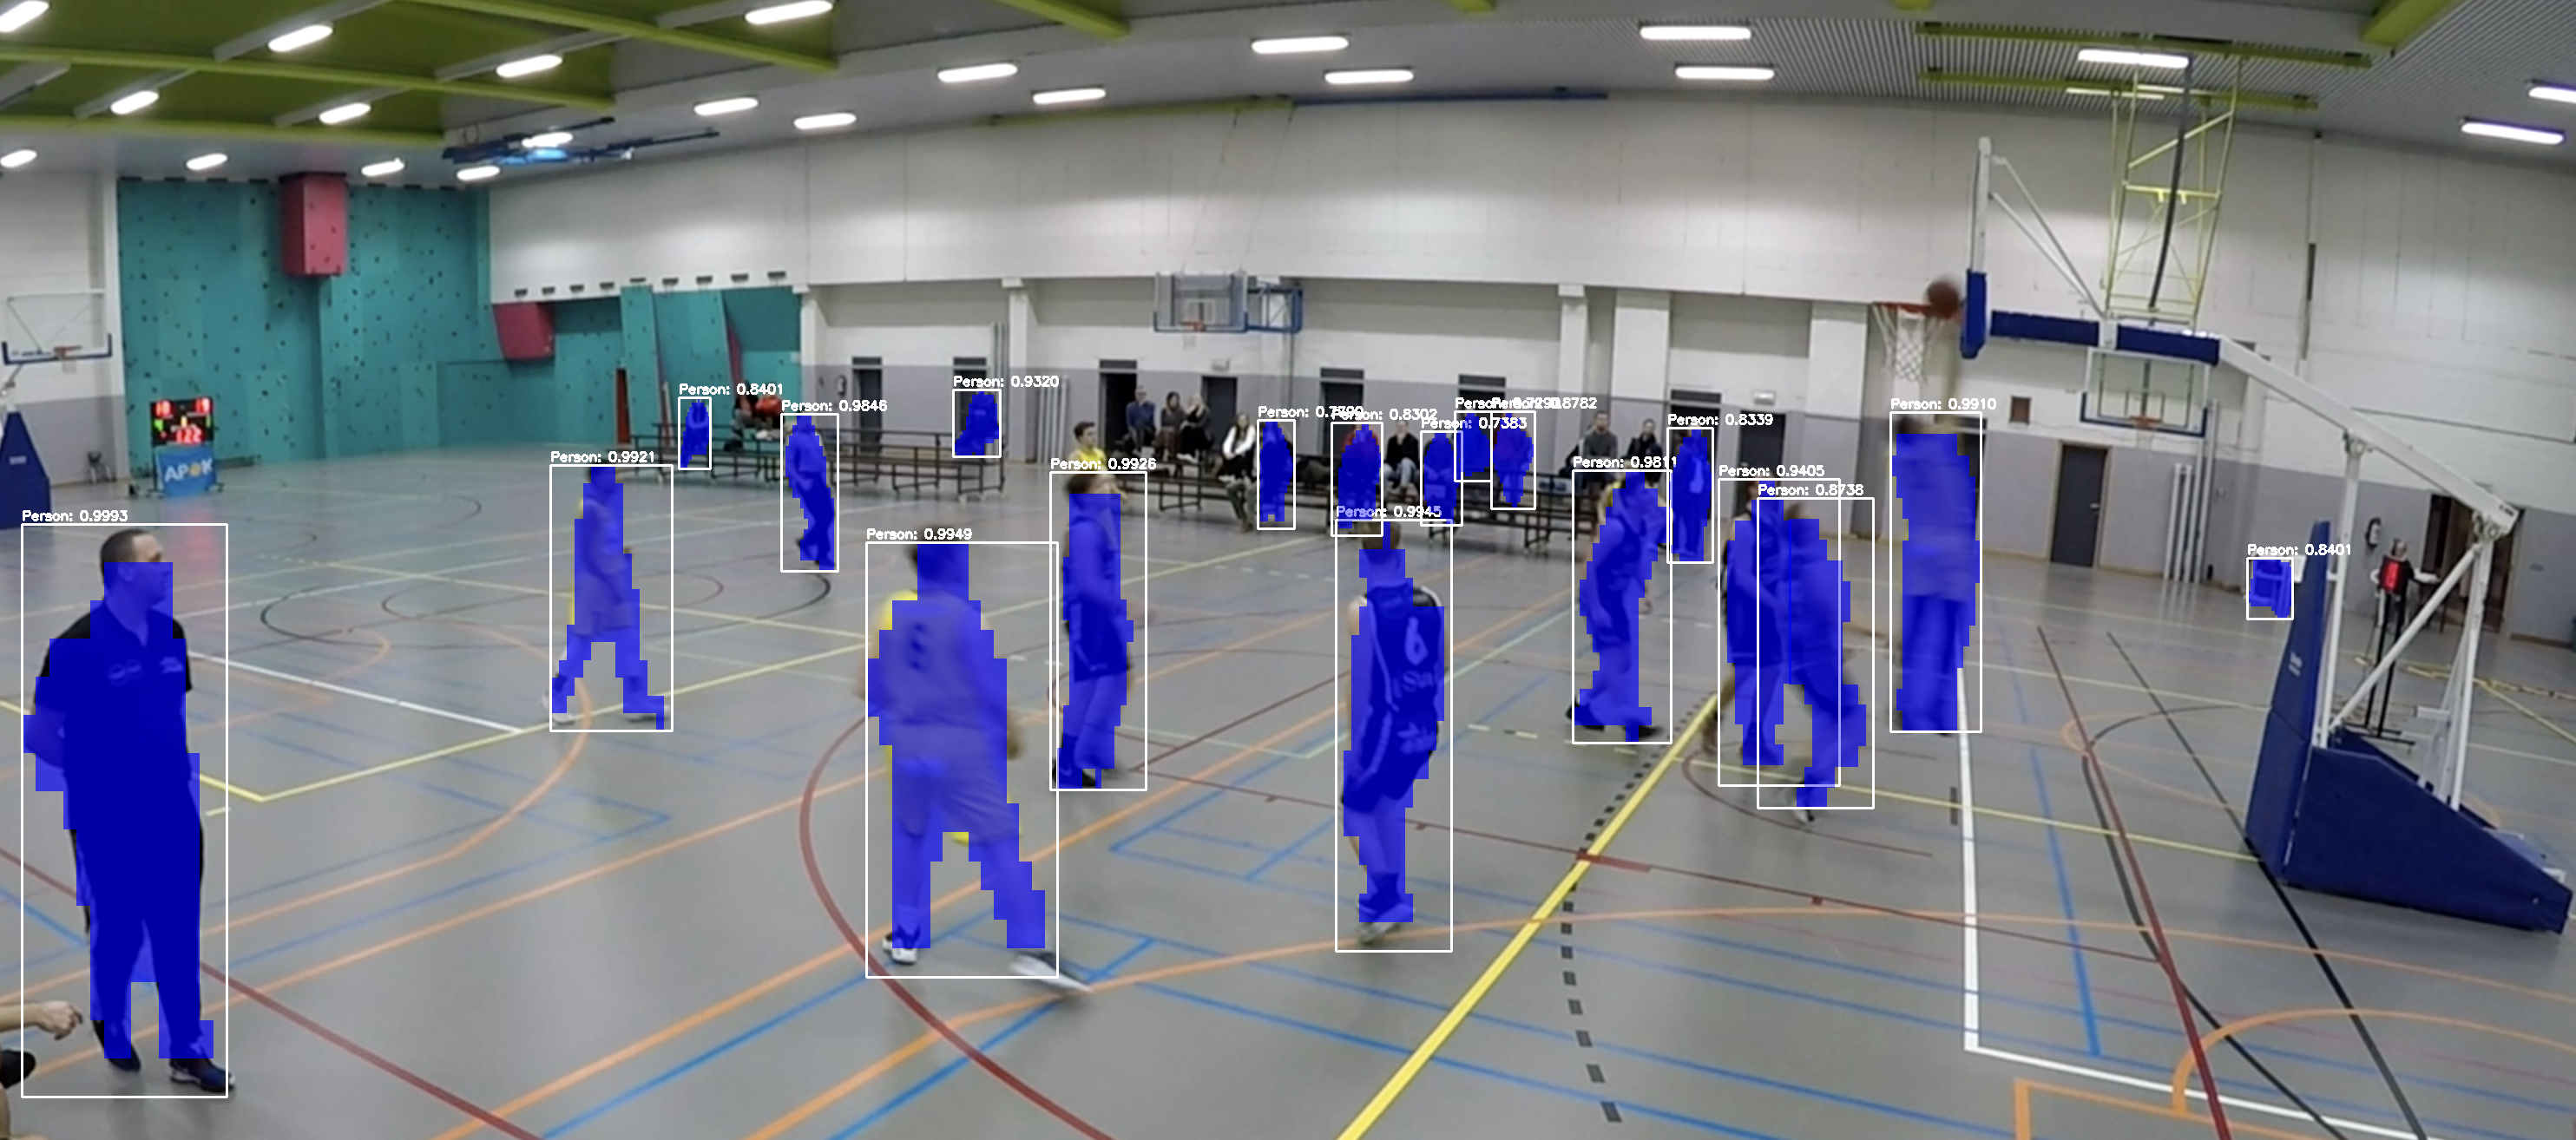

In [5]:
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):

	# extract the class ID of the detection along with the confidence
	# (i.e., probability) associated with the prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

	# filter out weak predictions by ensuring the detected probability
	# is greater than the minimum probability
	if confidence > 0.7:
		# clone our original image so we can draw on it
		# clone = image.copy()

		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the height
		# of the bounding box
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

		# extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions of the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH), interpolation = cv2.INTER_NEAREST)
		mask = (mask > 0.3)

		# extract the ROI of the image
		roi = image[startY:endY, startX:endX]
			
		# now, extract *only* the masked region of the ROI by passing in the boolean mask array as our slice condition
		roi = roi[mask]

		# Red will be used to visualize this particular instance segmentation 
		# then create a transparent overlay by blending the randomly selected color with the ROI
		blended = ((0.4 * RED_COLOR) + (0.6 * roi)).astype("uint8")

		# store the blended ROI in the original image
		image[startY:endY, startX:endX][mask] = blended

		# draw the bounding box of the instance on the image
		cv2.rectangle(image, (startX, startY), (endX, endY), (255,255,255), 2)

		# draw the predicted label and associated probability of the instance segmentation on the image
		text = "{}: {:.4f}".format("Person", confidence)
		cv2.putText(image, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

cv2_imshow(image)
		
